In [1]:
%load_ext autoreload

%autoreload 2
from astropy.io import fits as fits
import matplotlib.pyplot as plt
import pickle
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value


sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_miscentering as mis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
import CL_Mass_richness_relation as mass_richness
import analysis_Mass_Richness_relation as analysis
import multiprocessing
import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

In [2]:
name = '/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/matched_pairs_Mfofcut.fits'
dat = fits.open(name)
#mask = (match['redshift_1'] > .2)*(match['redshift_1'] < 1)
#mask = mask*(match['obs_2'] > 20)*(match['obs_1'] > 3e13)*(match['obs_2'] < 120)
#match = match[mask]

In [3]:
dat_open= dat[1].data

In [4]:
dat_open

FITS_rec([('10', 0.5135129 , 52.52043643, -25.71799612, 190.70665  , 3.7469666,  1312945563, 0.51072353, 0.79138356, '1162500021323', '1162500021323', '1162500021323,922700021315,205900021323,417800021323,665600021315,1361100021315,711400021315,80500021323', '80500021323,922700021315,205900021323,417800021323,665600021315,1361100021315,711400021315,1162500021323', 0.44967262, 0.30094044, '1162500021323', 0.44967262, '1162500021323', 0.51072352, 52.52043643, -25.71799612, 5.46154289e+14, 3.26491145e+14, 1.15600879e+12, '10', '10', '10', '10', 0.44967262, 0.30094044, '10', 0.30094044),
          ('18', 0.5712697 , 56.92037653, -27.20434071, 179.12813  , 3.6934361,  2000524808, 0.5740297 , 0.99996513, '549500032315', '549500032315', '549500032315', '549500032315', 0.94216489, 0.35064935, '549500032315', 0.94216489, '549500032315', 0.57402969, 56.92037653, -27.20434071, 1.00953537e+15, 6.45749231e+14, 1.58908916e+11, '18', '18', '18', '18', 0.94216489, 0.35064935, '18', 0.35064935),
      

In [5]:
richness = dat_open['cat1_richness']
redshift = dat_open['cat2_z']
M200c = dat_open['cat2_M200c']

In [6]:
table = Table()

In [7]:
table['richness'] = dat_open['cat1_richness']
table['M200c'] = dat_open['cat2_M200c']
table['redshift'] = dat_open['cat1_ztrue_cg']
table = table[(table['M200c'] > 1e11)*(table['richness'] > 20)*(table['redshift'] < 2)]

Text(0.5, 0, 'Richness')

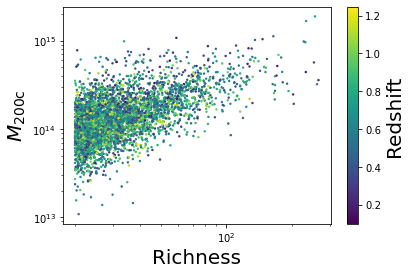

In [8]:
plt.scatter(table['richness'], table['M200c'], c=table['redshift'], s=2)
plt.colorbar().set_label(label=r'Redshift',size=20,)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$M_{\rm 200c}$', fontsize=20)
plt.xlabel('Richness', fontsize=20)

In [9]:
mr = mass_richness.WL_Mass_Richness()
mr.set_pivot_values(analysis.z0, analysis.richness0)

In [15]:
def lnLikelihood(p):
    log10m0, G, F, sigma_int = p
 
    if sigma_int < 0: return -np.inf
    if log10m0 < 0: return -np.inf
    sigma_int_correct = np.sqrt(sigma_int**2 + F**2/table['richness'])
    for s in sigma_int_correct:
        if s < 0: return -np.inf
    mu_lnm = mr.lnM(table['richness'], table['redshift'], [log10m0, G, F]) - sigma_int_correct**2/2
    p= np.exp(-.5*(np.log(table['M200c'])-mu_lnm)**2/(sigma_int_correct**2))/(np.sqrt(2*np.pi*sigma_int_correct**2))
    return np.sum(np.log(p))

In [16]:
lnLikelihood([14,1,1, .1])

-12918.805045885374

In [17]:
ncpu = multiprocessing.cpu_count()
print('You have {0:1d} CPUs'.format(ncpu))
pool = multiprocessing.Pool(processes=ncpu) 

You have 16 CPUs


In [14]:
nwalker=50
pos=.001*np.random.randn(nwalker,4) + np.array(np.array([14.15, -.4, .7, .4]))
sampler = emcee.EnsembleSampler(nwalker, 4, lnLikelihood, pool=pool)
sampler.run_mcmc(pos, 200, progress=True);
flat_samples1 = sampler.get_chain(discard=10, thin=3, flat=True)

100%|██████████| 200/200 [00:10<00:00, 19.94it/s]


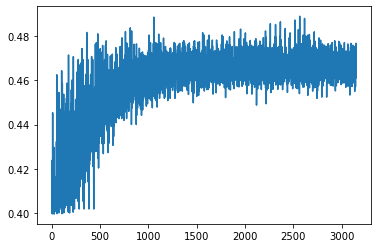

In [127]:
plt.plot(flat_samples1[:,3])

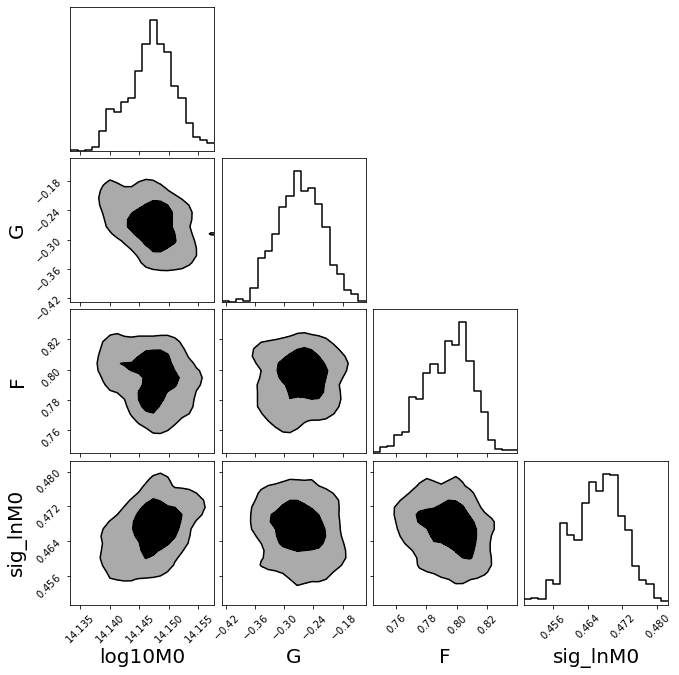

In [18]:
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
fig = corner.corner(flat_samples1[2500:], ls = '--', levels=[sigma1, sigma2],
    smooth1d=False,smooth=True,plot_datapoints=False,
    fill_contours=True, 
    label_kwargs={"fontsize": 20},
    use_math_text=True,
    show_title = True,
                    bins=20,
    plot_density=False,
    max_n_ticks = 5, labels = ['log10M0', 'G', 'F', 'sig_lnM0'])

In [19]:
logm, G, F, s, = np.mean(flat_samples1[2900:], axis=0)

In [20]:
np.array([logm, G, F, s])

array([14.1472071 , -0.27428836,  0.79383841,  0.46656339])

In [24]:
labels = ['log10M0', 'G', 'F', 'sig_lnM0']
for i in range(4):
    mcmc = np.percentile(flat_samples1[2900:][:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    print(txt)

\mathrm{log10M0} = 14.147_{-0.004}^{0.003}
\mathrm{G} = -0.277_{-0.042}^{0.054}
\mathrm{F} = 0.797_{-0.021}^{0.011}
\mathrm{sig_lnM0} = 0.467_{-0.005}^{0.005}


In [21]:
plt.scatter( match['obs_2'],match['obs_1'])
richness = np.linspace(20, 300, 100)
plt.plot(richness, np.exp(mr.lnM(richness, .2, [logm, G, F])), '--k')
plt.loglog()

TypeError: 'module' object is not subscriptable